# 简介

在上一篇文章中,我们对数据进行了初步的EDA操作,本文我们结合上一篇文章的EDA介绍一种线上线下一致的方案,该方案是我们目前多种建模方案中一个非常重要的组成部分,目前该方案在初期可以拿到线上线下一致的结果,可以帮助大家进行特征的构建。

本文我们仅仅给出该方案的大致框架,大家在该框架的基础上进行特征工程的构建,就可以帮助大家拿到线上0.697左右的分数,为了不影响很多赛友,我们不会开源特别高的分数, 此处仅给出多分类方案的一套完整的框架, 大家可以在此基础上进行修改, 祝大家比赛愉快。




# 工具包导入&数据读取
## 工具包导入

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import json 
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from itertools import product
import ast
# pd.options.display.precision = 15

In [2]:
lgb.__version__

'2.2.3'

## 数据读取

In [3]:
path = '/data/Data_JieZhang/KDD/'

train_queries = pd.read_csv(path + 'train_queries.csv', parse_dates=['req_time'])
train_plans   = pd.read_csv(path + 'train_plans.csv', parse_dates=['plan_time'])
train_clicks  = pd.read_csv(path + 'train_clicks.csv')
profiles      = pd.read_csv(path + 'profiles.csv') 

test_queries  = pd.read_csv(path + 'test_queries.csv', parse_dates=['req_time'])
test_plans    = pd.read_csv(path + 'test_plans.csv', parse_dates=['plan_time'])

# 特征工程

- 此处我们对所有表格进行合并,这样方便提取表格之间的交互特征,注意因为初赛的数据相对较少,所以我们才合在一起,不然尽量不要做,这样会给机器的内存带来非常大的负担.

## 数据集合并
 

In [4]:
train = train_queries.merge(train_plans, 'left', ['sid'])
test  = test_queries.merge(test_plans, 'left', ['sid'])

train = train.merge(train_clicks, 'left', ['sid'])
train['click_mode'] = train['click_mode'].fillna(0).astype(int)
data  = pd.concat([train, test], ignore_index=True)

data  = data.merge(profiles, 'left', ['pid']) 

## od(经纬度)特征
- 因为经纬度是组合字符串特征,此处我们对其进行还原,因为o,d本身是有相对大小关系的,我们不再对其进行编码。

In [5]:
data['o_lng'] = data['o'].apply(lambda x: float(x.split(',')[0]))
data['o_lat'] = data['o'].apply(lambda x: float(x.split(',')[1]))
data['d_lng'] = data['d'].apply(lambda x: float(x.split(',')[0]))
data['d_lat'] = data['d'].apply(lambda x: float(x.split(',')[1])) 

## plan_time & req_time特征
### 原始特征
时间信息会影响我们的决定,比如大晚上从A地到B地其实很多人是不会选择步行的,更多的会选择打车之类的,因为太黑了,怕迷路等;而如果是早高峰,而且离公司就几公里的情况, 那么一般就不会打车，因为特别会容易堵车,这个时候大家更喜欢骑自行车.

- 此处我们提取weekday来标志是周几; hour来标志是当日几点.


In [6]:
time_feature = []
for i in ['req_time']:
    data[i + '_hour'] = data[i].dt.hour
    data[i + '_weekday'] = data[i].dt.weekday
    time_feature.append(i + '_hour')
    time_feature.append(i + '_weekday') 

### plan_time & req_time差值特征

我们做EDA的时候发现plan_time和req_time并不是完全一样的,有的有一些时间差,我们猜测可能是手机的网速等问题,所以我们做差值来标志用户的手机信号等信息.


In [7]:
data['time_diff'] = data['plan_time'].astype(int) - data['req_time'].astype(int)
time_feature.append('time_diff')

## plans特征

plans这个数据集包含的信息非常多,因为这个信息是基于百度地图推荐的。所以毫无疑问是本次比赛的关键之一,我们对其进行展开并提取相关的特征。

此处我发现kdd已经有大佬开源了plans的特征提取关键代码,我感觉很不错,此处我便直接引用,至于其他的特征欢迎去作者的Github下载.

此处关于plans的特征主要可以归纳为如下的特征:

1. 百度地图推荐的距离的统计值(mean,min,max,std)
2. 各种交通方式的价格的统计值(mean,min,max,std)
3. 各种交通方式的时间的统计值(mean,min,max,std)
4. 一些其他的特征,最大距离的交通方式,最高价格的交通方式,最短时间的交通方式等.

In [8]:
data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))

In [19]:
rank_feature      =  []
for i in range(data['plans_json'].apply(len).max()):
    rank_feature.append('price_' + str(i))
    rank_feature.append('eta_' + str(i))
    rank_feature.append('distance_' + str(i)) 
    data['rank_' + str(i)]     = data['plans_json'].apply(lambda x: x[i]['transport_mode'] if len(x) > i else None)
    data['price_' + str(i)]    = data['plans_json'].apply(lambda x: x[i]['price'] if len(x) > i else None)
    data['price_' + str(i)]    = data['price_' + str(i)].apply(lambda x: 0 if x == ''or x is None else float(x))
    data['eta_' + str(i)]      = data['plans_json'].apply(lambda x: x[i]['eta'] if len(x) > i else None)
    data['distance_' + str(i)] = data['plans_json'].apply(lambda x: x[i]['distance'] if len(x) > i else None)
    if i == 0:
        continue
    rank_feature.append('rank_' + str(i))

In [10]:
def gen_plan_feas(data):
    n                                           = data.shape[0]
    mode_list_feas                              = np.zeros((n, 12))
    max_dist, min_dist, mean_dist, std_dist     = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_price, min_price, mean_price, std_price = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_eta, min_eta, mean_eta, std_eta         = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    min_dist_mode, max_dist_mode, min_price_mode, max_price_mode, min_eta_mode, max_eta_mode, first_mode = \
    np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
  
    mode_texts = []
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list   = []
        else:
            cur_plan_list   = plan
        if len(cur_plan_list) == 0:
            mode_list_feas[i, 0] =  1
            first_mode[i]        =  0

            max_dist[i]          = -1
            min_dist[i]          = -1
            mean_dist[i]         = -1
            std_dist[i]          = -1

            max_price[i]         = -1
            min_price[i]         = -1
            mean_price[i]        = -1
            std_price[i]         = -1

            max_eta[i]           = -1
            min_eta[i]           = -1
            mean_eta[i]          = -1
            std_eta[i]           = -1

            min_dist_mode[i]     = -1
            max_dist_mode[i]     = -1
            min_price_mode[i]    = -1
            max_price_mode[i]    = -1
            min_eta_mode[i]      = -1
            max_eta_mode[i]      = -1

            mode_texts.append('word_null')
        else:
            distance_list = []
            price_list = []
            eta_list = []
            mode_list = []
            for tmp_dit in cur_plan_list:
                distance_list.append(int(tmp_dit['distance']))
                if tmp_dit['price'] == '':
                    price_list.append(0)
                else:
                    price_list.append(int(tmp_dit['price']))
                eta_list.append(int(tmp_dit['eta']))
                mode_list.append(int(tmp_dit['transport_mode']))
            mode_texts.append(
                ' '.join(['word_{}'.format(mode) for mode in mode_list]))
            distance_list                = np.array(distance_list)
            price_list                   = np.array(price_list)
            eta_list                     = np.array(eta_list)
            mode_list                    = np.array(mode_list, dtype='int')
            mode_list_feas[i, mode_list] = 1
            distance_sort_idx            = np.argsort(distance_list)
            price_sort_idx               = np.argsort(price_list)
            eta_sort_idx                 = np.argsort(eta_list)

            max_dist[i]                  = distance_list[distance_sort_idx[-1]]
            min_dist[i]                  = distance_list[distance_sort_idx[0]]
            mean_dist[i]                 = np.mean(distance_list)
            std_dist[i]                  = np.std(distance_list)

            max_price[i]                 = price_list[price_sort_idx[-1]]
            min_price[i]                 = price_list[price_sort_idx[0]]
            mean_price[i]                = np.mean(price_list)
            std_price[i]                 = np.std(price_list)

            max_eta[i]                   = eta_list[eta_sort_idx[-1]]
            min_eta[i]                   = eta_list[eta_sort_idx[0]]
            mean_eta[i]                  = np.mean(eta_list)
            std_eta[i]                   = np.std(eta_list)

            first_mode[i]                = mode_list[0]
            max_dist_mode[i]             = mode_list[distance_sort_idx[-1]]
            min_dist_mode[i]             = mode_list[distance_sort_idx[0]]

            max_price_mode[i]            = mode_list[price_sort_idx[-1]]
            min_price_mode[i]            = mode_list[price_sort_idx[0]]

            max_eta_mode[i]              = mode_list[eta_sort_idx[-1]]
            min_eta_mode[i]              = mode_list[eta_sort_idx[0]]

    feature_data                   =  pd.DataFrame(mode_list_feas)
    feature_data.columns           =  ['mode_feas_{}'.format(i) for i in range(12)]
    feature_data['max_dist']       =  max_dist
    feature_data['min_dist']       =  min_dist
    feature_data['mean_dist']      =  mean_dist
    feature_data['std_dist']       =  std_dist

    feature_data['max_price']      = max_price
    feature_data['min_price']      = min_price
    feature_data['mean_price']     = mean_price
    feature_data['std_price']      = std_price

    feature_data['max_eta']        = max_eta
    feature_data['min_eta']        = min_eta
    feature_data['mean_eta']       = mean_eta
    feature_data['std_eta']        = std_eta

    feature_data['max_dist_mode']  = max_dist_mode
    feature_data['min_dist_mode']  = min_dist_mode
    feature_data['max_price_mode'] = max_price_mode
    feature_data['min_price_mode'] = min_price_mode
    feature_data['max_eta_mode']   = max_eta_mode
    feature_data['min_eta_mode']   = min_eta_mode
    feature_data['first_mode']     = first_mode
    print('mode tfidf...')
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_vec = tfidf_enc.fit_transform(mode_texts)
    svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
    mode_svd = svd_enc.fit_transform(tfidf_vec)
    mode_svd = pd.DataFrame(mode_svd)
    mode_svd.columns = ['svd_mode_{}'.format(i) for i in range(10)]

    plan_fea = pd.concat([feature_data, mode_svd], axis=1)
    plan_fea['sid'] = data['sid'].values
    return plan_fea

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [12]:
data_plans = gen_plan_feas(data)
plan_features = [col for col in data_plans.columns if col not in ['sid']]

594358it [01:24, 7032.82it/s]


mode tfidf...


In [13]:
data = data.merge(data_plans, on='sid', how='left')

# 模型训练&验证&提交
## 模型训练&验证

### 评估指标设计
- 为了对线上线下有一定的了解,我们尽可能设计和线上一样的评估,下面是lgb的评估函数

In [15]:
def f1_weighted(labels,preds):
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True

### 模型验证
- 此处我们模拟线上,选用7天的时间作为验证集.

In [14]:
data['pid'] = data['pid'].fillna(-1).astype(int)

In [17]:
%%time
profile_feature    = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature
cate_feature       = ['pid']  
feature            = origin_num_feature + cate_feature + plan_features + time_feature + rank_feature
 
train_index = (data.req_time < '2018-11-23')
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)

test_index = (data.req_time > '2018-12-01')
test_x     = data[test_index][feature].reset_index(drop=True)

print(len(feature), feature)

lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=2000, objective='multiclass',
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,
    learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)

eval_set = [(valid_x, valid_y)]
lgb_model.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted,verbose=10, early_stopping_rounds=100)


121 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'pid', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3',

In [28]:
S = 0.014053913260960742 #0.01625252
A = 63388 #94358 #92571

In [29]:
np.sqrt(((A*S) ** 2 / 8 + A**2 * S) / 2 ) + (A*S/4)

5541.0

In [27]:

Num0      = 8898
A         = 94358
Precision = Num0 / A
Recall    =  1
 
w0        = Num0 / A

w0 * (2 * Precision * Recall) / ( Precision + Recall) 

0.016252522441261897

In [14]:
import numpy as np
import pandas as pd

In [21]:
a = pd.read_csv('/data/Data_JieZhang/KDD/test_queries.csv')

In [22]:
a.shape

(94358, 5)

In [74]:
data['click_time'] = pd.to_datetime(data['click_time'])
data['time_delay'] = (data['click_time'] - data['req_time']).dt.seconds 

In [92]:
data['time_delay'] = data['time_delay'].fillna(data['time_delay'].max() + 100)

In [94]:
profile_feature    = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature
cate_feature       = ['pid']  
feature            = origin_num_feature + cate_feature + plan_features + time_feature 
 
train_index = (data.req_time < '2018-11-23') # &  (data.click_time.isnull() == False)
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].time_delay.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01') # & (data.plan_time.isnull() == False)
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].time_delay.reset_index(drop=True)

In [79]:
data.plan_time.isnull().sum()

10733

In [96]:
import os  
i = 0
meta_train = np.zeros(shape = ((len(tra)),1))
from sklearn.model_selection import StratifiedKFold,KFold 
skf = KFold(n_splits=5, shuffle=True)
pred_test = 0
for tr_ind,te_ind in skf.split(train_y):
    print('FOLD: '.format(i))
    print(len(te_ind),len(tr_ind)) 
    X_train,X_train_label = train_x.iloc[tr_ind],train_y.values[tr_ind]
    X_val,X_val_label     = train_x.iloc[te_ind],train_y.values[te_ind]
    
    model =  lgb.LGBMRegressor(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
        max_depth=-1, n_estimators=1000, objective='mae',
        subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,
        learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)

    eval_set = [(X_val, X_val_label)]
    model.fit(X_train, X_train_label, eval_set=eval_set, eval_metric='mae',verbose=10, early_stopping_rounds=100)
 
    pred_val = model.predict(X_val).reshape(-1,1) 
    pred_test += model.predict(valid_x) / 5
    
    meta_train[te_ind] = pred_val  


FOLD: 
87323 349289
Training until validation scores don't improve for 100 rounds.
[10]	valid_0's l1: 7590.04
[20]	valid_0's l1: 7225.84
[30]	valid_0's l1: 7007.8
[40]	valid_0's l1: 6877.26
[50]	valid_0's l1: 6799.1
[60]	valid_0's l1: 6752.3
[70]	valid_0's l1: 6724.28
[80]	valid_0's l1: 6707.5
[90]	valid_0's l1: 6697.45
[100]	valid_0's l1: 6691.43
[110]	valid_0's l1: 6687.83
[120]	valid_0's l1: 6685.67
[130]	valid_0's l1: 6684.38
[140]	valid_0's l1: 6683.6
[150]	valid_0's l1: 6683.14
[160]	valid_0's l1: 6682.86
[170]	valid_0's l1: 6682.69
[180]	valid_0's l1: 6682.59
[190]	valid_0's l1: 6682.53
[200]	valid_0's l1: 6682.5
[210]	valid_0's l1: 6682.48
[220]	valid_0's l1: 6682.46
[230]	valid_0's l1: 6682.45
[240]	valid_0's l1: 6682.45
[250]	valid_0's l1: 6682.44
[260]	valid_0's l1: 6682.44
[270]	valid_0's l1: 6682.44
[280]	valid_0's l1: 6682.44
[290]	valid_0's l1: 6682.44
[300]	valid_0's l1: 6682.44
[310]	valid_0's l1: 6682.44
[320]	valid_0's l1: 6682.44
[330]	valid_0's l1: 6682.44
[340]	va

[30]	valid_0's l1: 6944.75
[40]	valid_0's l1: 6811.14
[50]	valid_0's l1: 6731.14
[60]	valid_0's l1: 6683.25
[70]	valid_0's l1: 6654.57
[80]	valid_0's l1: 6637.39
[90]	valid_0's l1: 6627.11
[100]	valid_0's l1: 6620.95
[110]	valid_0's l1: 6617.27
[120]	valid_0's l1: 6615.06
[130]	valid_0's l1: 6613.74
[140]	valid_0's l1: 6612.94
[150]	valid_0's l1: 6612.47
[160]	valid_0's l1: 6612.18
[170]	valid_0's l1: 6612.01
[180]	valid_0's l1: 6611.91
[190]	valid_0's l1: 6611.85
[200]	valid_0's l1: 6611.81
[210]	valid_0's l1: 6611.79
[220]	valid_0's l1: 6611.78
[230]	valid_0's l1: 6611.77
[240]	valid_0's l1: 6611.76
[250]	valid_0's l1: 6611.76
[260]	valid_0's l1: 6611.76
[270]	valid_0's l1: 6611.76
[280]	valid_0's l1: 6611.76
[290]	valid_0's l1: 6611.75
[300]	valid_0's l1: 6611.75
[310]	valid_0's l1: 6611.75
[320]	valid_0's l1: 6611.75
[330]	valid_0's l1: 6611.75
[340]	valid_0's l1: 6611.75
[350]	valid_0's l1: 6611.75
[360]	valid_0's l1: 6611.75
[370]	valid_0's l1: 6611.75
[380]	valid_0's l1: 6611.75

In [97]:
data.loc[train_index, 'pred_click_time'] = meta_train
data.loc[valid_index, 'pred_click_time'] = pred_test

In [98]:
%%time
profile_feature    = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature
cate_feature       = ['pid']  
feature            = origin_num_feature + cate_feature + plan_features + time_feature  + ['pred_click_time']
 
train_index = (data.req_time < '2018-11-23')
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)
 
print(train_x.shape)
print(len(feature), feature)

lgb_model1 = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=2000, objective='multiclass',
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,
    learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)

eval_set = [(valid_x, valid_y)]
lgb_model1.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted,verbose=10, early_stopping_rounds=100)

(436612, 116)
116 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'pid', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2',

In [100]:
%%time
profile_feature    = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature
cate_feature       = ['pid']  
feature            = origin_num_feature + cate_feature + plan_features + time_feature  + ['pred_click_time']
 
train_index = (data.req_time < '2018-11-23')
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)
 
print(train_x.shape)
print(len(feature), feature)

lgb_model3 = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=2000, objective='multiclass',class_weight=dict(zip(range(12),[0.85,0.9,0.8,1,1.6,0.4,1.15,0.9,1.2,1.1,1,1.5])), 
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,
    learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)

eval_set = [(valid_x, valid_y)]
lgb_model3.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted,verbose=10, early_stopping_rounds=100)

(436612, 116)
116 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'pid', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2',

In [101]:
0.693341 -  0.689471

0.00387000000000004

In [102]:
%%time
profile_feature    = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature
cate_feature       = ['pid']  
feature            = origin_num_feature + cate_feature + plan_features + time_feature  
 
train_index = (data.req_time < '2018-11-23')
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)
 
print(train_x.shape)
print(len(feature), feature)

lgb_model4 = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=2000, objective='multiclass',class_weight=dict(zip(range(12),[0.85,0.9,0.8,1,1.6,0.4,1.15,0.9,1.2,1.1,1,1.5])), 
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,
    learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)

eval_set = [(valid_x, valid_y)]
lgb_model4.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted,verbose=10, early_stopping_rounds=100)

(436612, 115)
115 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'pid', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2',

In [103]:
data['importance'] = (pd.to_datetime(data['click_time']) - pd.to_datetime(data['plan_time'])).dt.seconds
def get_weight(x):
    if x <= 3:
        return 10
    elif x <= 10:
        return 3
    elif x <= 15:
        return 2
    return 1
    
data['importance'] = data['importance'].apply(lambda x:get_weight(x))

NameError: name 'data_' is not defined

In [105]:
%%time
profile_feature    = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature
cate_feature       = ['pid']  
feature            = origin_num_feature + cate_feature + plan_features + time_feature  + ['pred_click_time']
 
train_index = (data.req_time < '2018-11-23')
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)
train_w     = data[train_index][weight].values

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)
 
print(train_x.shape)
print(len(feature), feature)

lgb_model4 = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=2000, objective='multiclass',class_weight=dict(zip(range(12),[0.85,0.9,0.8,1,1.6,0.4,1.15,0.9,1.2,1.1,1,1.5])), 
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,
    learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)

eval_set = [(valid_x, valid_y)]
lgb_model4.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted,sample_weight=train_w,verbose=10, early_stopping_rounds=100)

(436612, 116)
116 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'pid', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2',

In [114]:
# pred_val = pd.DataFrame(lgb_model4.predict_proba(valid_x))
# pred_val.columns = ['pred_'+str(i) for i in range(12)]

# for i in range(1,50):
#     a = pred_val[['pred_'+str(i) for i in range(12)]]
    
#     a['pred_0'] = a['pred_0'] * 1
#     a['pred_1'] = a['pred_1'] * 0.8
#     a['pred_2'] = a['pred_2'] * 0.7
#     a['pred_4'] = a['pred_4'] * 0.6
#     a['pred_5'] = a['pred_5'] * 1.9
#     a['pred_6'] = a['pred_6'] * 1.25
#     a['pred_7'] = a['pred_7'] * 0.9
#     a['pred_8'] = a['pred_8'] * 1.2
#     a['pred_9'] = a['pred_9'] * 1.1
#     a['pred_11'] = a['pred_11'] * (0.1 + i/10)
#     pred_label = a.values.argmax(axis=1)
#     print((0.1 + i/10),f1_score(y_true=valid_y, y_pred=pred_label, average='weighted'))

In [99]:
%%time
profile_feature    = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature
cate_feature       = ['pid']  
feature            = origin_num_feature + cate_feature + plan_features + time_feature  
 
train_index = (data.req_time < '2018-11-23')
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)
 
print(train_x.shape)
print(len(feature), feature)

lgb_model2 = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=2000, objective='multiclass',
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,
    learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)

eval_set = [(valid_x, valid_y)]
lgb_model2.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted,verbose=10, early_stopping_rounds=100)

(436612, 115)
115 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'pid', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2',

In [84]:
imp = pd.DataFrame()
imp['fea'] = feature
imp['imp'] = lgb_model1.feature_importances_ 
imp = imp.sort_values('imp',ascending = False)
imp

,fea,imp
115,pred_click_time,14674
86,std_dist,10252
94,std_eta,9901
0,o_lng,8862
1,o_lat,8510
2,d_lng,8430
92,min_eta,8258
70,pid,7758
3,d_lat,7578
91,max_eta,7139


In [20]:
%%time
profile_feature    = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature
cate_feature       = ['pid']  
feature            = origin_num_feature + cate_feature + plan_features + time_feature + rank_feature
 
train_index = (data.req_time < '2018-11-23')
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)

test_index = (data.req_time > '2018-12-01')
test_x     = data[test_index][feature].reset_index(drop=True)

print(len(feature), feature)

lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=2000, objective='multiclass',
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,
    learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)

eval_set = [(valid_x, valid_y)]
lgb_model.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted,verbose=10, early_stopping_rounds=100)


142 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'pid', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3',

## 特征重要性分析
### 特征重要性分析

通过模型跑出来的结果,我们发现:
- pid特征是最重要的,这并不奇怪,因为pid在本次比赛中是一种聚类特征,表示某一类人,比如有一类pid表示有钱人,那么这些人基本都是有房有车的,所以出行也都是驾车出行,那么他们基本都是选择自驾的;

- 另外我们发现时间的方差和距离的方差也是极其重要的特征,这也很好解释,因为std可以认为是一种分布的表示特征,如果std大标明不同的出行方式的差别极大,比如从A到B,步行需要2h,而做地铁只需要10min,那么毫无疑问,90%的人会考虑步行.

- req_time_hour也是非常重要的特征,不同时段人们选择的交通方式是不一样的,所以也是可以理解的.

In [26]:
imp = pd.DataFrame()
imp['fea'] = feature
imp['imp'] = lgb_model.feature_importances_ 
imp = imp.sort_values('imp',ascending = False)
imp

,fea,imp
70,pid,14065
94,std_eta,2969
1,o_lat,2300
101,first_mode,2270
0,o_lng,2261
2,d_lng,2145
86,std_dist,2125
112,req_time_hour,2082
104,svd_mode_2,2032
84,min_dist,1998


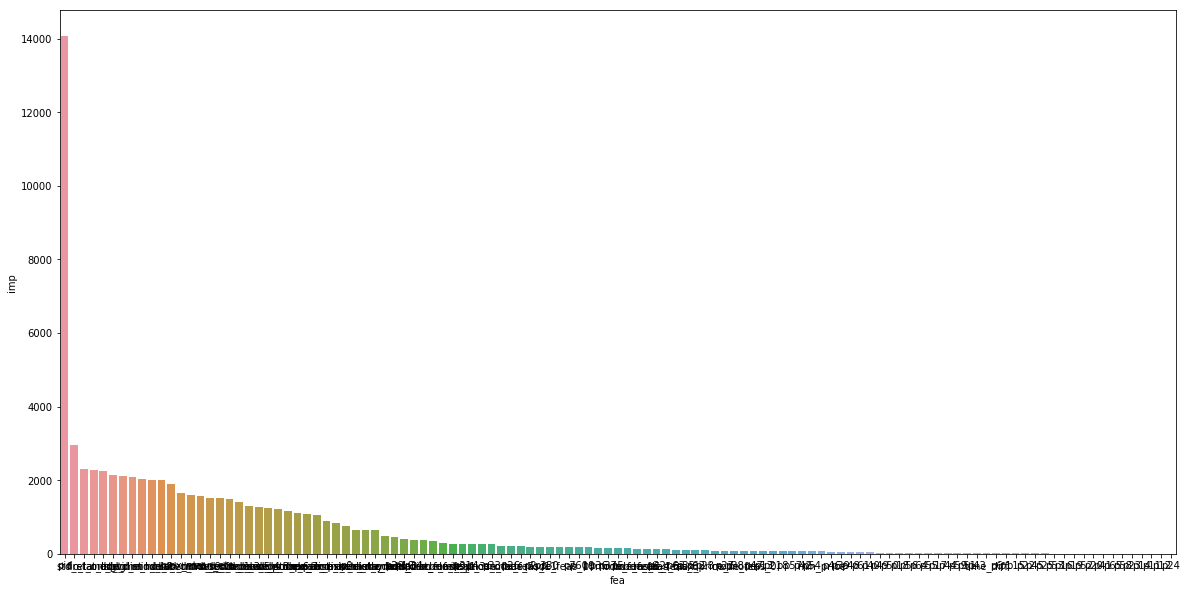

In [28]:
plt.figure(figsize=[20,10])
sns.barplot(x = 'fea', y ='imp',data = imp)

### 预测结果分析

除了对特征进行分析,我们再来分析每个类的预测结果,
- 我们发现0,4,6,8的recall很差,也就是说很多都没预测出来,可能需要通过很多其他的手段对其进行处理.
- 至于为什么预测不好,是不是特征没提好,还是参数不行,还是其他原因,希望大家自行探索.

In [29]:
pred = lgb_model.predict(valid_x) 
df_analysis = pd.DataFrame()
df_analysis['sid']   = data[valid_index]['sid']
df_analysis['label'] = valid_y.values
df_analysis['pred']  = pred 

In [30]:
df_analysis['label'] = df_analysis['label'].astype(int)

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,recall_score,precision_score
dic_ = df_analysis['label'].value_counts(normalize = True)
def get_weighted_fscore(y_pred, y_true):
    f_score = 0
    for i in range(12):
        yt = y_true == i
        yp = y_pred == i
        f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
        print(i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp))
    print(f_score)
get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])

0 0.08741402158137186 0.3445328617742411 0.9389558232931727 0.2109727486013355
1 0.1446172777181801 0.6844648581407587 0.6095960456792228 0.7802988982218828
2 0.313324288508866 0.9012450882923827 0.8504355595264687 0.9585116560092644
3 0.04459834669022528 0.08536585365853659 0.4602076124567474 0.04704633887513265
4 0.024452577774973182 0.017687934301958308 0.42424242424242425 0.00903225806451613
5 0.0975736732504575 0.8408789264120337 0.7729429307306493 0.9219078415521422
6 0.01989335520918786 0.16304347826086954 0.34177215189873417 0.1070578905630452
7 0.17792011106203068 0.7875073199297286 0.7034944549068843 0.894307501330023
8 0.004559222565785322 0.2505307855626327 0.3241758241758242 0.2041522491349481
9 0.04993058623083233 0.5150723122495208 0.5742035742035742 0.4669826224328594
10 0.028475421215371995 0.5524308865586273 0.4847344207444584 0.6421052631578947
11 0.007241118192717865 0.4618784530386741 0.46860986547085204 0.4553376906318083
0.6870639391098695


## 模型训练&提交

我们使用上面的最优的迭代次数作为我们模型的迭代次数进行线上结果的提交,该方案线上的成绩应该在0.680-0.690之间,具体多少分欢迎有兴趣的同学自自己提交。


In [33]:
all_train_x              = data[data.req_time < '2018-12-01'][feature].reset_index(drop=True)
all_train_y              = data[data.req_time < '2018-12-01'].click_mode.reset_index(drop=True)
print(lgb_model.best_iteration_)
lgb_model.n_estimators   = lgb_model.best_iteration_
lgb_model.fit(all_train_x, all_train_y,categorical_feature=cate_feature)
print('fit over')
result                   = pd.DataFrame()
result['sid']            = data[test_index]['sid']
result['recommend_mode'] = lgb_model.predict(test_x)
result['recommend_mode'] = result['recommend_mode'].astype(int)
print(len(result))
print(result['recommend_mode'].value_counts())
result[['sid', 'recommend_mode']].to_csv(path + '/sub/baseline.csv', index=False)

# 其他开源代码

下面是两份非常不错的开源代码,有兴趣的同学可以去看看.

1. https://github.com/yaoxuefeng6/Paddle_baseline_KDD2019
2. https://github.com/jiuxianghedonglu/Context-Aware-Multi-Modal-Transportation-Recommendation/tree/master/code

# 小结

本篇文章,我们基于上一篇的EDA,给出了我们目前方案中的最重要方案之一 --- **多分类模型部分**,本文给出了我们多分类方案的整体框架,部分重要的基础特征工程,以及较为一致的线下验证方案与结果分析方案,通过增加特征等方案,该方案可以取得线上0.697左右的成绩。

最后感谢两位大佬的开源以及有夕的代码框架！祝大家比赛愉快,不管结果如何,我们的方案会在比赛结束后和大家一起分享。

